In [1]:
!python -m pip install gymnasium==0.28.1
!python -m pip install stable-baselines3[extra]==2.1.0
!python -m pip install ax-platform==0.3.4
!python -m pip install wandb==0.15.12

In [2]:
# Check versions
import importlib.metadata

print(f"torch version: {importlib.metadata.version('torch')}")
print(f"gymnasium version: {importlib.metadata.version('gymnasium')}")
print(f"sb3 version: {importlib.metadata.version('stable-baselines3')}")
print(f"cv2 version: {importlib.metadata.version('opencv-python')}")
print(f"ax version: {importlib.metadata.version('ax-platform')}")

torch version: 2.0.1+cu118
gymnasium version: 0.28.1
sb3 version: 2.1.0
cv2 version: 4.8.0.76
ax version: 0.3.4


In [3]:
import time
import datetime
import os
import random
import logging
from typing import Any, Dict, Tuple, Union

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import cv2
import wandb

import stable_baselines3 as sb3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger

from ax.service.ax_client import AxClient
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
[WARNING 10-12 03:12:19] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [4]:
# Log in to Weights & Biases
wandb.login()

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

wandb: Currently logged in as: shawnhymel. Use `wandb login --relogin` to force relogin


True

In [5]:
# Make wandb be quiet
os.environ["WANDB_SILENT"] = "true"
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Helper functions

In [6]:
def set_random_seeds(seed: int, using_cuda: bool = False) -> None:
  """
  Seed the different random generators.
  """

  # Set seed for Python random, NumPy, and Torch
  random.seed(seed)
  np.random.seed(seed)
  th.manual_seed(seed)

  # Set deterministic operations for CUDA
  if using_cuda:
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False

## Set up environment

In [7]:
# Create the environment
# https://gymnasium.farama.org/environments/classic_control/pendulum/
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [8]:
# Reset the pendulum environment
obs, info = env.reset()
print(obs)
print(info)

[0.98093146 0.19435388 0.6942826 ]
{}


(500, 500, 3)


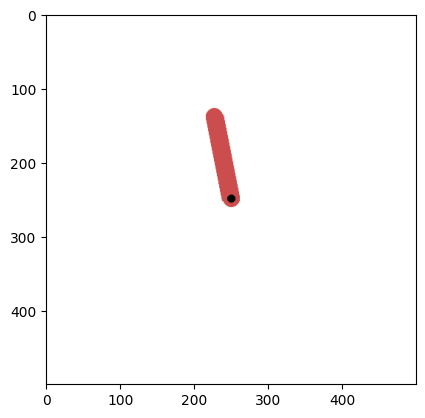

In [9]:
# Render the environment (render is not the observation!) and get width/height
frame = env.render()
width = frame.shape[1]
height = frame.shape[0]

# Show frame
print(frame.shape)
plt.imshow(frame)

In [10]:
# Function that tests the model in the given environment
def test_agent(env, model, max_steps=0, video=None, msg=None):

  # Reset environment
  obs, info = env.reset()
  ep_len = 0
  ep_rew = 0
  avg_step_time = 0.0

  # Run episode until complete
  while True:

    # Provide observation to policy to predict the next action
    timestamp = time.time()
    action, _ = model.predict(obs)

    # Perform action, update total reward
    obs, reward, terminated, truncated, info = env.step(action)
    avg_step_time += time.time() - timestamp
    ep_rew += reward

    # Record frame to video
    if video:
      frame = env.render()
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      frame = cv2.putText(
          frame,                        # Image
          msg,                          # Text to add
          (10, 25),                     # Origin of text in image
          cv2.FONT_HERSHEY_SIMPLEX,     # Font
          1,                            # Font scale
          (0, 0, 0),                    # Color
          2,                            # Thickness
          cv2.LINE_AA                   # Line type
      )
      video.write(frame)

    # Increase step counter
    ep_len += 1
    if (max_steps > 0) and (ep_len >= max_steps):
      break

    # Check to see if episode has ended
    if terminated or truncated:
      break

  # Calculate average step time
  avg_step_time /= ep_len

  return ep_len, ep_rew, avg_step_time

In [11]:
class DummyAgent():
  """
  Agent that just predicts random actions
  """

  # Save environment
  def __init__(self, env):
    self.env = env

  # Always output random action regardless of observation
  def predict(self, obs):
    action = self.env.action_space.sample()
    return action, None

In [12]:
# Recorder settings
FPS = 30
FOURCC = cv2.VideoWriter.fourcc('m', 'p', '4', 'v')
VIDEO_FILENAME = "1-random.mp4"

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Try runnign a few episodes with the environment and random actions
dummy_agent = DummyAgent(env)
for ep in range(5):
  ep_len, ep_rew, step_time = test_agent(env, dummy_agent, max_steps=100, video=video, msg=f"Random, episode {ep}")
  print(f"Episode {ep} | Length: {ep_len}, Reward: {ep_rew}, Step time: {(step_time * 1000):.2e} ms")

# Close the video writer
video.release()

Episode 0 | Length: 100, Reward: -616.6691684993609, Step time: 3.18e-01 ms
Episode 1 | Length: 100, Reward: -603.0561702820014, Step time: 3.24e-01 ms
Episode 2 | Length: 100, Reward: -695.7293665369457, Step time: 2.99e-01 ms
Episode 3 | Length: 100, Reward: -743.3874459309851, Step time: 2.84e-01 ms
Episode 4 | Length: 100, Reward: -486.37857900471533, Step time: 1.04e+00 ms


## Testing and logging callbacks

In [13]:
# Evaluate agent on a number of tests
def evaluate_agent(env, model, steps_per_test, num_tests):

  # Initialize metrics
  avg_ep_len = 0
  avg_ep_rew = 0
  avg_step_time = 0.0

  # Test the agent a number of times
  for ep in range(num_tests):
    ep_len, ep_rew, step_time = test_agent(env, model, max_steps=steps_per_test)
    avg_ep_len += ep_len
    avg_ep_rew += ep_rew
    avg_step_time += step_time

  # Compute metrics
  avg_ep_len /= num_tests
  avg_ep_rew /= num_tests
  avg_step_time /= num_tests

  return avg_ep_len, avg_ep_rew, avg_step_time

In [29]:
class EvalAndSaveCallback(BaseCallback):
  """
  Evaluate and save the model every ``check_freq`` steps
  """

  # Constructor
  def __init__(
      self,
      check_freq,
      save_dir,
      model_name="model",
      replay_buffer_name=None,
      steps_per_test=0,
      num_tests=10,
      step_offset=0,
      verbose=1,
  ):
    super(EvalAndSaveCallback, self).__init__(verbose)
    self.check_freq = check_freq
    self.save_dir = save_dir
    self.model_name = model_name
    self.replay_buffer_name = replay_buffer_name
    self.num_tests = num_tests
    self.steps_per_test = steps_per_test
    self.step_offset = step_offset
    self.verbose = verbose

  # Create directory for saving the models
  def _init_callback(self):
    if self.save_dir is not None:
      os.makedirs(self.save_dir, exist_ok=True)

  # Save and evaluate model at a set interval
  def _on_step(self):
    if self.n_calls % self.check_freq == 0:

      # Set actual number of steps (including offset)
      actual_steps = self.step_offset + self.n_calls

      # Save model
      model_path = os.path.join(self.save_dir, f"{self.model_name}_{str(actual_steps)}")
      self.model.save(model_path)

      # Save replay buffer
      if self.replay_buffer_name != None:
        replay_buffer_path = os.path.join(self.save_dir, f"{self.replay_buffer_name}")
        self.model.save_replay_buffer(replay_buffer_path)

      # Evaluate the agent
      avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
          env,
          self.model,
          self.steps_per_test,
          self.num_tests
      )
      if self.verbose:
        print(f"{str(actual_steps)} steps | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")

      # Log metrics to WandB
      log_dict = {
          'avg_ep_len': avg_ep_len,
          'avg_ep_rew': avg_ep_rew,
          'avg_step_time': avg_step_time,
          'train/actor_loss': self.model.logger.name_to_value['train/n_updates'],
          'train/approx_k1': self.model.logger.name_to_value['train/approx_k1'],
          'train/clip_fraction': self.model.logger.name_to_value['train/clip_fraction'],
          'train/clip_range': self.model.logger.name_to_value['train/clip_range'],
          'train/critic_loss': self.model.logger.name_to_value['train/critic_loss'],
          'train/ent_coef': self.model.logger.name_to_value['train/ent_coef'],
          'train/ent_coef_loss': self.model.logger.name_to_value['train/ent_coef_loss'],
          'train/entropy_loss': self.model.logger.name_to_value['train/entropy_loss'],
          'train/explained_variance': self.model.logger.name_to_value['train/explained_variance'],
          'train/learning_rate': self.model.logger.name_to_value['train/learning_rate'],
          'train/loss': self.model.logger.name_to_value['train/loss'],
          'train/n_updates': self.model.logger.name_to_value['train/n_updates'],
          'train/policy_gradient_loss': self.model.logger.name_to_value['train/policy_gradient_loss'],
          'train/value_loss': self.model.logger.name_to_value['train/value_loss'],
          'train/std': self.model.logger.name_to_value['train/std'],
      }
      wandb.log(log_dict, commit=True, step=actual_steps)

    return True

In [30]:
class WandBWriter(KVWriter):
  """
  Log metrics to Weights & Biases when called by .learn()
  """

  # Initialize run
  def __init__(self, run, verbose=1):
    super().__init__()
    self.run = run
    self.verbose = verbose

  # Write metrics to W&B project
  def write(
    self,
    key_values: Dict[str, Any],
    key_excluded: Dict[str, Union[str, Tuple[str, ...]]],
    step: int = 0,
  ) -> None:

    log_dict = {}

    # Go through each key/value pairs
    for (key, value), (_, excluded) in zip(
      sorted(key_values.items()), sorted(key_excluded.items())):

      if self.verbose >= 2:
        print(f"step={step} | {key} : {value} ({type(value)})")

      # Skip excluded items
      if excluded is not None and "wandb" in excluded:
        continue

      # Log integers and floats
      if isinstance(value, np.ScalarType):
        if not isinstance(value, str):
          wandb.log(data={key: value}, step=step)
          log_dict[key] = value

    # Print to console
    if self.verbose >= 1:
      print(f"Log for steps={step}")
      print(f"--------------")
      for (key, value) in sorted(log_dict.items()):
        print(f"  {key}: {value}")
      print()

  # Close the W&B run
  def close(self) -> None:
    self.run.finish()

## Define train and test function for a single trial

In [31]:
def do_trial(settings, hparams):
  """
  Training loop used to evaluate a set of hyperparameters
  """

  # Set random seed
  set_random_seeds(settings['seed'], using_cuda=th.cuda.is_available())

  # Create new W&B run
  config = {}
  dt = datetime.datetime.now(datetime.timezone.utc)
  dt = dt.replace(microsecond=0, tzinfo=None)
  run = wandb.init(
      project=settings['wandb_project'],
      name=str(dt),
      config=config,
      settings=wandb.Settings(silent=(not settings['verbose_wandb']))
  )

  # Print run info
  if settings['verbose_trial'] > 0:
    print(f"WandB run ID: {run.id}")
    print(f"WandB run name: {run.name}")

  # Log hyperparameters to W&B
  wandb.config.update(hparams)

  # Set custom Logger with our custom writer
  wandb_writer = WandBWriter(run, verbose=settings['verbose_log'])
  loggers = Logger(
      folder=None,
      output_formats=[wandb_writer]
  )

  # Calculate derived hyperparameters
  n_steps = 2 ** hparams['steps_per_update_pow2']
  minibatch_size = (hparams['n_envs'] * n_steps) // (2 ** hparams['batch_size_div_pow2'])
  layer_1 = 2 ** hparams['layer_1_pow2']
  layer_2 = 2 ** hparams['layer_2_pow2']

  # Set completed steps to checkpoint number (in filename) or 0 to start over
  # TODO: how to resume if trial is paused/cancelled
  completed_steps = 0

  # Load or create new model
  if completed_steps != 0:
    model_path = os.path.join(settings['save_dir'], f"{settings['model_name']}_{str(completed_steps)}.zip")
    model = sb3.PPO.load(model_path, env)
    steps_to_complete = settings['total_steps'] - completed_steps
  else:
    model = sb3.PPO(
        'MlpPolicy',
        env,
        learning_rate=hparams['learning_rate'],
        n_steps=n_steps,
        batch_size=minibatch_size,
        gamma=hparams['gamma'],
        ent_coef=hparams['entropy_coef'],
        use_sde=hparams['use_sde'],
        sde_sample_freq=hparams['sde_freq'],
        policy_kwargs={'net_arch': [layer_1, layer_2]},
        verbose=settings['verbose_train'],
    )
    steps_to_complete = settings['total_steps']

  # Set up checkpoint callback
  checkpoint_callback = EvalAndSaveCallback(
      check_freq=settings['checkpoint_freq'],
      save_dir=settings['save_dir'],
      model_name=settings['model_name'],
      replay_buffer_name=settings['replay_buffer_name'],
      steps_per_test=settings['steps_per_test'],
      num_tests=settings['tests_per_check'],
      step_offset=(settings['total_steps'] - steps_to_complete),
      verbose=settings['verbose_test'],
  )

  # Choo choo train
  model.learn(total_timesteps=steps_to_complete,
              callback=[checkpoint_callback])

  # Get dataframe of run metrics
  history = wandb.Api().run(f"{run.project}/{run.id}").history()

  # Get index of evaluation with maximum reward
  max_idx = np.argmax(history.loc[:, 'avg_ep_rew'].values)

  # Find number of steps required to produce that maximum reward
  max_rew_steps = history['_step'][max_idx]
  if settings['verbose_trial'] > 0:
    print(f"Steps with max reward: {max_rew_steps}")

  # Load model with maximum reward from previous run
  model_path = os.path.join(settings['save_dir'], f"{settings['model_name']}_{str(max_rew_steps)}.zip")
  model = sb3.PPO.load(model_path, env)

  # Evaluate the agent
  avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
      env,
      model,
      settings['steps_per_test'],
      settings['tests_per_check'],
  )

  # Log final evaluation metrics to WandB run
  wandb.run.summary['Average test episode length'] = avg_ep_len
  wandb.run.summary['Average test episode reward'] = avg_ep_rew
  wandb.run.summary['Average test step time'] = avg_step_time

  # Print final run metrics
  if settings['verbose_trial'] > 0:
    print('---')
    print(f"Best model: {settings['model_name']}_{str(max_rew_steps)}.zip")
    print(f"Average episode length: {avg_ep_len}")
    print(f"Average episode reward: {avg_ep_rew}")
    print(f"Average step time: {avg_step_time}")

  # Close W&B run
  run.finish()

  return avg_ep_rew

## Perform trials

In [60]:
# Project settings that do not change
settings = {
    'wandb_project': "pendulum-ax-hpo",
    'model_name': "ppo-pendulum",
    'ax_experiment_name': "ppo-pendulum-experiment",
    'ax_objective_name': "avg_ep_rew",
    'replay_buffer_name': None,
    'save_dir': "checkpoints",
    'checkpoint_freq': 10_000,
    'steps_per_test': 100,
    'tests_per_check': 10,
    'total_steps': 100_000,
    'num_trials': 50,
    'seed': 42,
    'verbose_ax': False,
    'verbose_wandb': False,
    'verbose_train': 0,
    'verbose_log': 0,
    'verbose_test': 0,
    'verbose_trial': 1,
}

In [61]:
# Define the hyperparameters we want to optimize
hparams = [
  {
    'name': "n_envs",
    'type': "fixed",
    'value_type': "int",
    'value': 1,
  },
  {
    'name': "learning_rate",
    'type': "range",
    'value_type': "float",
    'bounds': [1e-5, 1e-2],
    'log_scale': True,
  },
  {
    'name': "steps_per_update_pow2",
    'type': "range",
    'value_type': "int",
    'bounds': [6, 12],    # Inclusive, 2**n between [64, 4096]
    'log_scale': False,
  },
  {
    'name': "batch_size_div_pow2",
    'type': "range",
    'value_type': "int",
    'bounds': [0, 3],    # Inclusive, 2**n between [1, 8]
    'log_scale': False,
  },
  {
    'name': "gamma",
    'type': "range",
    'value_type': "float",
    'bounds': [0.9, 0.99],
    'log_scale': False,
  },
  {
    'name': "entropy_coef",
    'type': "range",
    'value_type': "float",
    'bounds': [0.0, 0.1],
    'log_scale': False,
  },
  {
    'name': "use_sde",
    'type': "choice",
    'value_type': "bool",
    'values': [True, False],
    'is_ordered': False,
    'sort_values': False,
  },
  {
    'name': "sde_freq",
    'type': "range",
    'value_type': "int",
    'bounds': [-1, 8],
    'log_scale': False,
  },
  {
    'name': "layer_1_pow2",
    'type': "range",
    'value_type': "int",
    'bounds': [5, 8],    # Inclusive, 2**n between [32, 256]
    'log_scale': False,
  },
  {
    'name': "layer_2_pow2",
    'type': "range",
    'value_type': "int",
    'bounds': [5, 8],    # Inclusive, 2**n between [32, 256]
    'log_scale': False,
  },
]

# Set parameter constraints
parameter_constraints = []

In [62]:
# Create our environment
try:
  env.close()
except NameError:
  pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [63]:
# Construct path to Ax experiment snapshot file
ax_snapshot_path = os.path.join(settings['save_dir'], f"{settings['ax_experiment_name']}.json")

In [64]:
# DANGER! Uncomment to delete the experiment file to start over
# os.remove(ax_snapshot_path)

In [65]:
# Load experiment from snapshot if it exists, otherwise create a new one
if os.path.exists(ax_snapshot_path):
  print(f"Loading experiment from snapshot: {ax_snapshot_path}")
  ax_client = AxClient.load_from_json_file(ax_snapshot_path)
else:
  print(f"Creating new experiment. Snapshot to be saved at {ax_snapshot_path}.")
  ax_client = AxClient(
      random_seed=settings['seed'],
      verbose_logging=settings['verbose_ax']
  )
  ax_client.create_experiment(
      name=settings['ax_experiment_name'],
      parameters=hparams,
      objective_name=settings['ax_objective_name'],
      minimize=False,
      parameter_constraints=parameter_constraints,
  )

Loading experiment from snapshot: checkpoints/ppo-pendulum-experiment.json


/usr/local/lib/python3.10/dist-packages/ax/core/parameter.py:517: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "use_sde". Defaulting to `True` for parameters of `ParameterType` BOOL. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [66]:
# Choo choo! Perform trials to optimize hyperparameters
while True:

  # Get next hyperparameters and end experiment if we've reached max trials
  next_hparams, trial_index = ax_client.get_next_trial()
  if trial_index >= settings['num_trials']:
    break

  # Show that we're starting a new trial
  if settings['verbose_trial'] > 0:
    print(f"--- Trial {trial_index} ---")

  # Perform trial
  avg_ep_rew = do_trial(settings, next_hparams)
  ax_client.complete_trial(
      trial_index=trial_index,
      raw_data=avg_ep_rew,
  )

  # Save experiment snapshot
  ax_client.save_to_json_file(ax_snapshot_path)

/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 30 ---


WandB run ID: ew013w2g
WandB run name: 2023-10-12 04:25:31
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -210.91877091894042
Average step time: 0.0005460917949676513


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 31 ---


WandB run ID: tu9x8pvw
WandB run name: 2023-10-12 04:27:31
Steps with max reward: 100000
---
Best model: ppo-pendulum_100000.zip
Average episode length: 100.0
Average episode reward: -215.27741470317216
Average step time: 0.0005431008338928223


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 32 ---


WandB run ID: x2d2b3xi
WandB run name: 2023-10-12 04:29:41
Steps with max reward: 70000
---
Best model: ppo-pendulum_70000.zip
Average episode length: 100.0
Average episode reward: -169.50121559907456
Average step time: 0.0008610973358154297


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 33 ---


WandB run ID: 3xhwfmuh
WandB run name: 2023-10-12 04:31:37
Steps with max reward: 80000
---
Best model: ppo-pendulum_80000.zip
Average episode length: 100.0
Average episode reward: -269.1187102474776
Average step time: 0.0005443634986877442


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 34 ---


WandB run ID: gb82s9n3
WandB run name: 2023-10-12 04:33:34
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -195.27214695057378
Average step time: 0.0005489308834075927


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 35 ---


WandB run ID: ra2istv4
WandB run name: 2023-10-12 04:35:31
Steps with max reward: 60000
---
Best model: ppo-pendulum_60000.zip
Average episode length: 100.0
Average episode reward: -264.7689149010463
Average step time: 0.0007185516357421874


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 36 ---


WandB run ID: bvw5thh8
WandB run name: 2023-10-12 04:37:30
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -159.05776882637522
Average step time: 0.0005649139881134034


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 37 ---


WandB run ID: xottnh9m
WandB run name: 2023-10-12 04:39:23
Steps with max reward: 80000
---
Best model: ppo-pendulum_80000.zip
Average episode length: 100.0
Average episode reward: -166.6587768736262
Average step time: 0.000553025484085083


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 38 ---


WandB run ID: j5fudzl9
WandB run name: 2023-10-12 04:41:19
Steps with max reward: 70000
---
Best model: ppo-pendulum_70000.zip
Average episode length: 100.0
Average episode reward: -127.43442811088073
Average step time: 0.0007308444976806641


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 39 ---


WandB run ID: a63oss6h
WandB run name: 2023-10-12 04:43:12
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -165.8087658848445
Average step time: 0.0005583646297454834


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 40 ---


WandB run ID: up2x5n79
WandB run name: 2023-10-12 04:45:10
Steps with max reward: 70000
---
Best model: ppo-pendulum_70000.zip
Average episode length: 100.0
Average episode reward: -191.2245009281018
Average step time: 0.0008799781799316406


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 41 ---


WandB run ID: sjjw83n6
WandB run name: 2023-10-12 04:47:03
Steps with max reward: 40000
---
Best model: ppo-pendulum_40000.zip
Average episode length: 100.0
Average episode reward: -229.87518150342174
Average step time: 0.000548222541809082


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 42 ---


WandB run ID: 7pkyng2j
WandB run name: 2023-10-12 04:48:59
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -152.5429615939733
Average step time: 0.0005572702884674072


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 43 ---


WandB run ID: 1tqfavls
WandB run name: 2023-10-12 04:51:01
Steps with max reward: 80000
---
Best model: ppo-pendulum_80000.zip
Average episode length: 100.0
Average episode reward: -310.28348874786275
Average step time: 0.0005423662662506103


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 44 ---


WandB run ID: 37tif9h4
WandB run name: 2023-10-12 04:53:05
Steps with max reward: 40000
---
Best model: ppo-pendulum_40000.zip
Average episode length: 100.0
Average episode reward: -228.14908205301532
Average step time: 0.0005645742416381836


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 45 ---


WandB run ID: i1ch30od
WandB run name: 2023-10-12 04:54:59
Steps with max reward: 60000
---
Best model: ppo-pendulum_60000.zip
Average episode length: 100.0
Average episode reward: -235.49446458756256
Average step time: 0.0006888923645019532


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 46 ---


WandB run ID: nv6w2sgf
WandB run name: 2023-10-12 04:57:03
Steps with max reward: 50000
---
Best model: ppo-pendulum_50000.zip
Average episode length: 100.0
Average episode reward: -185.9634651584709
Average step time: 0.0005688469409942627


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 47 ---


WandB run ID: r0qkqlzf
WandB run name: 2023-10-12 04:58:58
Steps with max reward: 50000
---
Best model: ppo-pendulum_50000.zip
Average episode length: 100.0
Average episode reward: -204.72612916522206
Average step time: 0.0005617232322692871


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 48 ---


WandB run ID: hxhj9832
WandB run name: 2023-10-12 05:00:53
Steps with max reward: 90000
---
Best model: ppo-pendulum_90000.zip
Average episode length: 100.0
Average episode reward: -199.2114442197589
Average step time: 0.0007584159374237062


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



--- Trial 49 ---


WandB run ID: 3tgno775
WandB run name: 2023-10-12 05:02:47
Steps with max reward: 80000
---
Best model: ppo-pendulum_80000.zip
Average episode length: 100.0
Average episode reward: -104.02972215405217
Average step time: 0.0005573461055755615


/usr/local/lib/python3.10/dist-packages/ax/modelbridge/transforms/winsorize.py:348: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



## Train agent with best hyperparameters

In [67]:
# Get from W&B dashboard
hparams = {
    'n_envs': 1,
    'learning_rate': 0.008588262476609402,
    'steps_per_update_pow2': 11,
    'batch_size_div_pow2': 2,
    'gamma': 0.925367066383774,
    'entropy_coef': 0.05427299351015017,
    'use_sde': False,
    'sde_freq': 6,
    'layer_1_pow2': 6,
    'layer_2_pow2': 6,
}

In [68]:
# Create our environment
try:
  env.close()
except NameError:
  env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [69]:
# Train model
_ = do_trial(settings, hparams)

WandB run ID: 2qei77jy
WandB run name: 2023-10-12 05:29:26
Steps with max reward: 70000
---
Best model: ppo-pendulum_70000.zip
Average episode length: 100.0
Average episode reward: -179.16185589598058
Average step time: 0.0006293234825134278


## Test trained agent

In [70]:
# Model and video settings
MODEL_FILENAME = "checkpoints/ppo-pendulum_70000.zip"
VIDEO_FILENAME = "2-testing.mp4"

# Create our environment
try:
  env.close()
except NameError:
  pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Load the model
model = sb3.PPO.load(MODEL_FILENAME)

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Test the model
ep_len, ep_rew, avg_step_time = test_agent(
    env,
    model,
    max_steps=200,
    video=video,
    msg=f"{MODEL_FILENAME}"
)
print(f"Episode length: {ep_len}, reward: {ep_rew}, avg step time: {avg_step_time}")

# Close the video writer
video.release()

Episode length: 200, reward: -127.95295503925935, avg step time: 0.0010370385646820068
